# Number classifier

The goal of this notebook is to train a model for classify the numbers detected in players shirt

## Load packages

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd
import cv2
import os
import imutils
from google.colab.patches import cv2_imshow
import pickle
import seaborn as sn

In [14]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data paths and data

In [15]:
drive_path = 'drive/MyDrive/Colab Notebooks/numbers_detection'

In [4]:
# load data from dataset
with open(drive_path+'/data.pickle', 'rb') as handle:
  [X_train, y_train, X_test, y_test] = pickle.load(handle)

## Dataset samples

In [9]:
X_train[10].shape

(224, 224, 3)

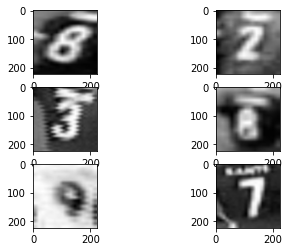

In [15]:
# examples of images
fig, axes = plt.subplots(3, 2)
axes = axes.ravel()

for ind in range(6):
  axes[ind].imshow(X_train[ind])

plt.show()

## Model architecture

In [ ]:
#CNN architecture

# Initialising the CNN
classifier = Sequential()

classifier.add(Conv2D(128, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Flatten())

classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


#Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=30,
    shear_range=0.5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False)


datagen.fit(X_train)


epochs = 80
batch_size = 32

H = classifier.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                         steps_per_epoch=len(X_train)/batch_size, 
                         validation_data=(X_test, y_test),
                         epochs=epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
90/90 [==============================] - 31s 332ms/step - loss: 2.1862 - accuracy: 0.1410 - val_loss: 2.1605 - val_accuracy: 0.1567
Epoch 2/80
90/90 [==============================] - 29s 324ms/step - loss: 2.1588 - accuracy: 0.1550 - val_loss: 2.1650 - val_accuracy: 0.1831
Epoch 3/80
90/90 [==============================] - 29s 323ms/step - loss: 2.1305 - accuracy: 0.1732 - val_loss: 2.1393 - val_accuracy: 0.1831
Epoch 4/80
90/90 [==============================] - 29s 325ms/step - loss: 2.1210 - accuracy: 0.1572 - val_loss: 2.1311 - val_accuracy: 0.1591
Epoch 5/80
90/90 [==============================] - 29s 326ms/step - loss: 2.1257 - accuracy: 0.1856 - val_loss: 2.1067 - val_accuracy: 0.2422
Epoch 6/80
90/90 [==============================] - 29s 323ms/step - loss: 2.0911 - accuracy: 0.2112 - val_loss: 1.9186 - val_accuracy: 0.2806
Epoch 7/80
90/90 [==============================] - 30s 327ms/step - loss: 2.0043 - accuracy: 0.2388 - val_loss: 1.7026 - val_accuracy: 0.3621

In [ ]:
# save model
classifier.save(drive_path+'/numbers_classifier_aug.h5')

## Plot performance

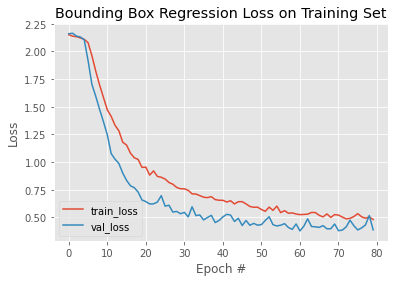

In [ ]:
# plot the model training history
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

### Confusion Matrix

In [ ]:

real = []
pred = []
for ind, img in enumerate(X_test):
  
  preds = classifier.predict(np.array([img]))[0]
  
  i = np.argmax(preds)

  #print(preds)
  #print(f'predicted: {i},\nreal:{np.argmax(y_train[ind])}\n\n')
  
  if preds[i] > 0:
    pred.append(i)
    real.append(np.argmax(y_test[ind]))

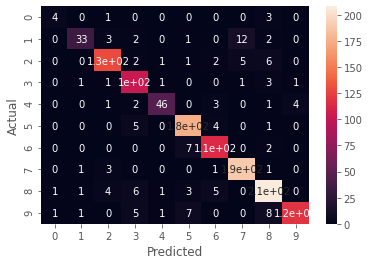

In [ ]:
data = {'y_Actual':    real,
        'y_Predicted': pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

### Plot example

In [18]:
image = load_img('drive/MyDrive/Colab Notebooks/numbers_detection/test/test_pos_image_crop/15001.jpg', target_size=(224, 224))
image = img_to_array(image) / 255.0

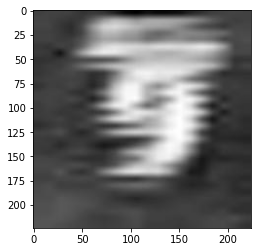

In [20]:
plt.imshow(image)

In [22]:
classifier = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/numbers_detection/numbers_classifier_aug.h5')


In [27]:
preds = classifier.predict(np.array([image]))

print(preds)
print(f"Most likely class: {preds.argmax()}")

1/1 [==============================] - 0s 137ms/step
[[0.00159129 0.00468426 0.00311618 0.13629493 0.00520281 0.01952036
  0.0012287  0.00098287 0.01933445 0.8080441 ]]
Most likely class: 9
